In [1]:
# 현재 만드는 AI는 
# 이전 3일(일수 변경 가능)의 확진자 수 추이를 보고 다음날의 확진자 수를 예측

# 연속된 데이터의 형태에서 그 패턴을 찾아내는 순환 신경망(RNN) 방식으로, 
# RNN의 기본적인 형탤르 설계하고 학습시켜본다.

#  케라스의 모델 도구 중 시퀀셜 모델 불러옴
from keras.models import Sequential

# 순환신경망(RNN) 기법에는 LSTM, GRU 등 다양한 기법이 있다.
# SimpleRNN은 가장 기본적인 RNN의 모습으로 LSTM과 GRU는 SimpleRNN을 한층 더 발전시킨 순환 신경망임
# Dense는 각 레이어에서 뉴런의 수이다. 각 레이어에 들어가는 뉴런의 수를 정할 때 사용한다.
from keras.layers import SimpleRNN, Dense

# 데이터 정규화를 위한 sklearn 라이브러리의 전처리 함수 사용
from sklearn.preprocessing import MinMaxScaler

# 결과 정확도를 계산하기 위한 함수를 불러옴
# 코로나 확진자 수를 예측하는 모델의 결과는 특정한 숫자로 나온다.
# 연속된 값을 예측하는 회귀 문제로 오차를 게산하는 방법 또한 분류 문제와 다르다.
# 이때 mean_squared_error로 실제 값과 예측 값의 차이를 사용해 오류를 구하는 역할
from sklearn.metrics import mean_squared_error

# 트레이닝 데이터와 테스트 데이터를 나누는 명령어
from sklearn.model_selection import train_test_split

import math
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv


In [2]:
# 데이터 가져오기
# git에 저자분이 올려주신 것을 불러옴 !git clone https://github.com/yhlee1627/deeplearning.git 을 이용해 먼저 불러오는 것을 수행해야 한다.

# 확진자 수만 사용해 모델을 생성할 것이므로 필요한 3번 컬럼만 받아옴 usecols=[3]으로
dataframe = read_csv('../data/corona_daily.csv', usecols=[3], engine='python', skipfooter=3)

print(dataframe)

dataset = dataframe.values
dataset = dataset.astype('float32') # 정규화를 위해 두 번째 행의 값을 실수로 변경 (정규화는 보통 나눗셈을 사용)

     Confirmed
0           24
1           24
2           27
3           27
4           28
..         ...
107      11190
108      11206
109      11225
110      11265
111      11344

[112 rows x 1 columns]


In [3]:
# 데이터 정규화 및 분류하기
# 인공지능 모델의 성능을 높이려면 데이터 정규화가 필요하다. 여기선 데이털르 0과 1사이로 만들어 사용

# 정규화하기 위한 방법을 scaler로 정하고, 이를 위해 사이킷런 라이브러리 중 MinMaxScaler 함수를 사용
scaler = MinMaxScaler(feature_range=(0, 1)) # 데이터 정규화 범이를 0, 1로 정함
Dataset = scaler.fit_transform(dataset) # 앞에서 만든 정규화 방법인 scaler를 사용한 후, MinMaxScaler 함수 중 fit_transform 함수를 사용해 데이터를 정규화함
train_data, test_data = train_test_split(Dataset, test_size=0.2, shuffle=False)

# 훈련데이터의 개수와 검증 데이터의 개수를 출력
print(len(train_data), len(test_data)) 

89 23


In [8]:
# 데이터의 형태 변경하기

# RNN(순환 신경망) 모델은 이전의 연속된 데이털르 사용해서 이후의 값을 예측한다.
# 1, 2, 3일차의 확진자 수(연속된 데이터)를 순환 신경망 모델에 넣으면 그 다음 날짜의 확진자 수, 즉 4일차 확진자 수를 예측해서 반환해 준다.
# 그리고 7, 8, 9일차를 넣으면 10일차를 예측해서 반환한다.

# 이러한 형태의 예측을 위해선 데이터의 모습 또한 이에 맞게 변경해야 한다.
# 그런데 우리가 가진 데이터는 한 줄로 쭉 나열된 모습이다. 따라서 인공지능 모델에 데이터를 입력하기 위해선 형태를 변경해야 한다.

# arg1 : 원래 데이터 arg2 : 연속되는 데이터의 개수
def create_dataset(dataset, look_back):
    x_data, y_data = [], []
    for i in range(len(dataset)-look_back):
        data = dataset[i:(i+look_back), 0]
        x_data.append(data)
        y_data.append(dataset[i + look_back, 0])
    return np.array(x_data), np.array(y_data)

In [9]:
# create input data
look_back = 3
x_train, y_train = create_dataset(train_data, look_back)
x_test, y_test = create_dataset(test_data, look_back)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(86, 3) (86,)
(20, 3) (20,)


In [10]:
# 인공지능 모델에 넣어줄 형태로 변환하기
# 현재 가진 것은 row 85, col 3인데 -> 인공지능에 넣을 땐 하나씩 따로 넣어야해서 1x3 형태 85개, 즉 85x1x3

X_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
X_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(X_train.shape)
print(X_test.shape)

(86, 1, 3)
(20, 1, 3)


In [11]:
# 인공지능 모델 만들기
# 일반적인 시퀀셜 모델은 입력데이터가 은닉층을 거쳐 출력층까지 간다.

# 순환 신경망은 첫 번째 데이터를 넣고 은닉층에 있는 파라미터들(가중치와 편형의 값)을 학습
# 그 학습 결괏값을 바로 출력하는 것이 아니라 다음 단계에서 참고할 수 있도록 넘겨줌
# 이후 똑같은 은닉층에 첫 번째 데이터를 넣고 학습한 결과와 함께 두 번째 데이털르 넣고 학습시킨다.
# 이때는 앞에서 첫 번쨰 값을 넣었을 때 학습한 결괏값을 포함해 학습을 시작하고, 다음 이 결과를 다시 다음 단계로 넘김
# 이후 이 결괏값과 세 번째 데이터를 넣고 학습시킨 후 최종값을 예측하는 구조

# RNN 역시 레이어들이 선형으로 연결되므로 시퀀셜 모델로
model = Sequential()

# RNN 기법 중 Simple RNN을 사용 (LSTM, GRU 등 다양한 기법이 있다.)
# 은닉층의 수는 3개 (랜덤하게 해도 됨), 넣는 데이터의 형태는 1x3의 형태를 넣음
model.add(SimpleRNN(3, input_shape = (1, look_back) ))

# 은닉층은 최종적으로 1개만 있으면 되고 l활성화 함수는 linear
model.add(Dense(1, activation="linear"))

# 인공지능을 계산하는 방법을 결정
# 손실함수는 mse(평균 제곱 오차, mean_squared_error)로, 옵티마이저는 adam 옵티마이저를 사용
# 실제 확진자의 수와 에측한 값의 차이를 바탕으로 오차를 나타낼 수 있으므로 평균 제곱 오차를 사용함.
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3)                 21        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 모델 학습시키기
# 에포크 : 반복 횟수, batch_size : 한번에 학습할 사이즈 , verbose 1 : 학습의 진행 결과를 에포크별로 간단히 알려줌
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose = 1)

Epoch 1/100
86/86 [==============================] - 1s 944us/step - loss: 0.0028
Epoch 2/100
86/86 [==============================] - 0s 938us/step - loss: 7.5213e-04
Epoch 3/100
86/86 [==============================] - 0s 980us/step - loss: 6.7225e-04
Epoch 4/100
86/86 [==============================] - 0s 1ms/step - loss: 6.2131e-04
Epoch 5/100
86/86 [==============================] - 0s 943us/step - loss: 6.1103e-04
Epoch 6/100
86/86 [==============================] - 0s 994us/step - loss: 5.9470e-04
Epoch 7/100
86/86 [==============================] - 0s 838us/step - loss: 6.1426e-04
Epoch 8/100
86/86 [==============================] - 0s 746us/step - loss: 5.2816e-04
Epoch 9/100
86/86 [==============================] - 0s 761us/step - loss: 5.9207e-04
Epoch 10/100
86/86 [==============================] - 0s 757us/step - loss: 6.0976e-04
Epoch 11/100
86/86 [==============================] - 0s 856us/step - loss: 5.2916e-04
Epoch 12/100
86/86 [==============================] - 0s 7

In [14]:
# 데이터 예측하기
# 모델의 성능을 측정하려면 실제 데이터를 예측한 값과 실제 데이터의 값의 차이를 봐야한다.
# 그러므로 정규화를 거친 결과가 아닌 실제 확진자 수 데이터가 필요하다.
# RNN 모델을 통해 나온 예측값을 정규화 되기 전으로 변환해 실제 값 또한 정규화되기 전의 값으로 변회시켜야함

# X_train, X_tst -> RNN Model -> RNN -> 예측값     실제값 <= Scaler <- y_train, y_test

trainPredict = model.predict(X_train) # 정규화된 값이 나옴
testPredict = model.predict(X_test)

# 실제 값으로 다시 바꾸기
TrainPredict = scaler.inverse_transform(trainPredict)
TestPredict = scaler.inverse_transform(testPredict)

Y_train = scaler.inverse_transform([y_train])
Y_test = scaler.inverse_transform([y_test])


1/1 [==============================] - 0s 21ms/step


In [16]:
print('Y_train : \n',Y_train)

print('\n Y_test: \n ', Y_test)

Y_train : 
 [[   27.00000082    28.00000066    28.00000066    28.00000066
     28.00000066    28.00000066    29.00000049    30.00000033
     31.00000016    51.00000214   104.00000395   204.00001384
    433.00000247   602.00000099   832.99993658   976.9999972
   1260.99992933  1766.00008335  2337.00011053  3150.00006622
   3736.00006457  4212.00004942  4811.99990841  5327.99992884
   5766.00009917  6284.00034066  6766.99991846  7134.00016901
   7381.99991731  7512.99972177  7754.99981896  7868.99993724
   7979.00028811  8086.0001387   8161.99976773  8236.00018779
   8320.00002636  8413.00001631  8564.9999491   8652.00028794
   8798.99983675  8897.00021069  8960.99986278  9037.00016654
   9136.99974945  9240.99977449  9331.99988074  9478.00016242
   9583.00012931  9661.00031677  9785.99979541  9886.99999489
   9976.00021744 10061.99993971 10155.99987151 10236.99988453
  10283.99985043 10330.99981633 10384.00010806 10422.99986443
  10450.00031858 10479.99992357 10512.00008698 10536.999982

In [15]:
# 모델의 정확도 살펴보기
# 모델이 예측한 값과 실제값에는 어느정도 차이가 있는 지보기
# 이때 사용하는 함수는 평균 제곱근 오차(Root Mean Squared Error)로 구함. 제곱을해서 수가 커지므로 root를 통헤 좀 작게 하는 처리

# mean_square_error는 사이킷런 라이브러리에서 가져옴 
trainScore = math.sqrt(mean_squared_error(Y_train[0], TrainPredict[:, 0]))
print('Train Score : %.2f RMSE' %(trainScore) ) #  출력할 변수를 % 뒤에 넣는다.

testScore = math.sqrt(mean_squared_error(Y_test[0], TestPredict[:, 0]))
print('Test Score : %.2f RMSE' %(testScore))

Train Score : 229.82 RMSE
Test Score : 388.76 RMSE


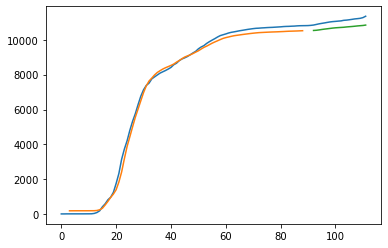

In [17]:
# 결과를 그래프로 확인하기

# RMSE(평균제곱근 오차)를 구해 모델의 정확도를 살펴봤지만, 이 점수만으론 모델의 정확도를 한눈에 파악하기 어렵다.
#그래서 실제 데이터의 G와 훈련 데이터를 예측한 그래프, 검증 데이터를 예측한 G를 한 번에 그려서 봄

# 훈련 데이터를 예측한 값을 저장할 배열 만들기 
trainPredictPlot = np.empty_like(dataset)  # dataset과 동일한 형태의 넘파일 배열을 만든
trainPredictPlot[:,:] = np.nan # 모두 값을 nan으로
# 3일차를 건너뛰고 4일차(look_back) 부터 TrainPredict 배열의 원소 수까지 len(TrainPredict) + look_back를 범위로 지정
# 그 부분에 데이터를 넣음
trainPredictPlot[look_back: len(TrainPredict) + look_back, :] = TrainPredict

# 초록색(검정)
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
# 뒷 부분에 집어 넣어서 겹치지 않게 하기 위해서
# 애초에 TrainPredict그릴때 계산한 lookback + TrainPredict 이후 + look_back*2(앞의 3일을 건너뛴 후 그 후에)
testPredictPlot[len(TrainPredict) + (look_back)*2 : len(dataset), : ] = TestPredict 

plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# 파란색 : 데이터 , 주황색 : 훈련, 초록색 : 검증